In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import yaml
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

In [3]:
def energies_vec(t, xs, vs, mwdflag, mwhflag, lmcflag, motion):
    """
    calculate the energies and angular momenta of particles for a given time snapshot.
    In the Galactocentric coordinate system. 
    xs,vs are already in GC coords.
    """
    # Kinetic energy
    Ek = (.5 * np.linalg.norm(vs, axis=1)**2) * (u.km/u.s)**2
    # Potential energy
    x0 = np.array(Model.expansion_centres(t))

    if motion == False:
        x0 *= 0 
    
    x_lmc_GC = x0[6:9] - x0[:3]
            
    pot_disk = Model.mwd_fields(t,  xs[:,0], xs[:,1], xs[:,2], mwdflag)[:,4]
    pot_halo = Model.mwhalo_fields(t, xs[:,0], xs[:,1], xs[:,2], mwhflag)[:,4]
    pot_lmc = Model.lmc_fields(t, 
                               xs[:,0] - x_lmc_GC[0],
                               xs[:,1] - x_lmc_GC[1],
                               xs[:,2] - x_lmc_GC[2],
                               lmcflag)[:,4]
    Ep = (pot_disk + pot_halo + pot_lmc) * (u.km/u.s)**2
    E = Ek + Ep
    return E

Visualising in stream coordinates

In [4]:
def stream_frame_comp(path, plotname, savefig=False):
    
    # folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    folders = list(['stream15', 'stream53', 'stream106'])
    
    dts = list(['dt_2myr.hdf5', 'dt_1myr.hdf5', 'dt_halfmyr.hdf5', 'dt_tenthmyr.hdf5']) 
    titles = list([r'$\mathrm{dt} = 2\,\mathrm{Myr}$', r'$\mathrm{dt} = 1\,\mathrm{Myr}$', 
                   r'$\mathrm{dt} = 0.5\,\mathrm{Myr}$', r'$\mathrm{dt} = 0.1\,\mathrm{Myr}$'])
    t_idx = -1
    
    fig, ax = plt.subplots(len(folders), len(dts), sharex='col', sharey='row', figsize=(12,6))
    plt.subplots_adjust(hspace=0, wspace=0.)
    
    for i in range(len(folders)): 
        for j in range(len(dts)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / folders[i] / dts[j]
            with h5py.File(data_path,'r') as file:
                prog = gd.PhaseSpacePosition(file["positions"][t_idx, 0] * u.kpc, file["velocities"][t_idx, 0] * u.km / u.s)
                stream = gd.PhaseSpacePosition(file["positions"][t_idx, 1:].T * u.kpc, file["velocities"][t_idx, 1:].T * u.km / u.s)
                start_times = np.array(file['times'])
                prog_mass = np.array(file['progenitor-mass']) * u.Msun
            #-------------------------------------------------------------------------------------
            ### Rotation matrix for progenitor to get it to near (X, 0, 0)
            #-------------------------------------------------------------------------------------
            R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
            R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
            R_prog0 = R2.as_matrix() @ R1.as_matrix()  
            #-------------------------------------------------------------------------------------
            ### Rotate around new x axis so stream prog vel points along +y direction
            #-------------------------------------------------------------------------------------
            new_vxyz = R_prog0 @ prog.v_xyz
            v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
            R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
            R = (R3 * R2 * R1).as_matrix()
            #-------------------------------------------------------------------------------------
            ### Rotate the whole stream by the final rotation matrix
            #-------------------------------------------------------------------------------------
            prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
            prog_sph = prog_rot.spherical
            stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
            stream_sph = stream_rot.spherical
            lon = stream_sph.lon.wrap_at(180*u.deg).degree
            lat = stream_sph.lat.degree
            #-------------------------------------------------------------------------------------
            ### Plot the streams
            #-------------------------------------------------------------------------------------
            plt.sca(ax[i,j])
            # print('* Plotting {} in potential {}'.format(streams[i], potentials[j]))
            plt.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plt.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, zorder=1)
            plot=plt.scatter(lon, lat, s=.5, c='k', alpha=.1, rasterized=True)
            
            if j==0:
                plt.annotate(text='{}'.format(folders[i]), xy=(-180,65), fontsize=8, color='red' )
                plt.annotate(text=r'M = {} $\times \, 10^{{4}} \, \mathrm{{M}}_{{\odot}}$'.format(np.round(prog_mass.value/1e4, 1)),
                             xy=(-180, -80), fontsize=8)
        
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(titles)):
        ax[0,k].set_title(titles[k])
        ax[-1,k].set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
        ax[-1,k].set_xlim(-199,199)
        
    for l in range(len(folders)):
        ax[l, 0].set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')
        ax[l, 0].set_ylim(-99,99)

    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

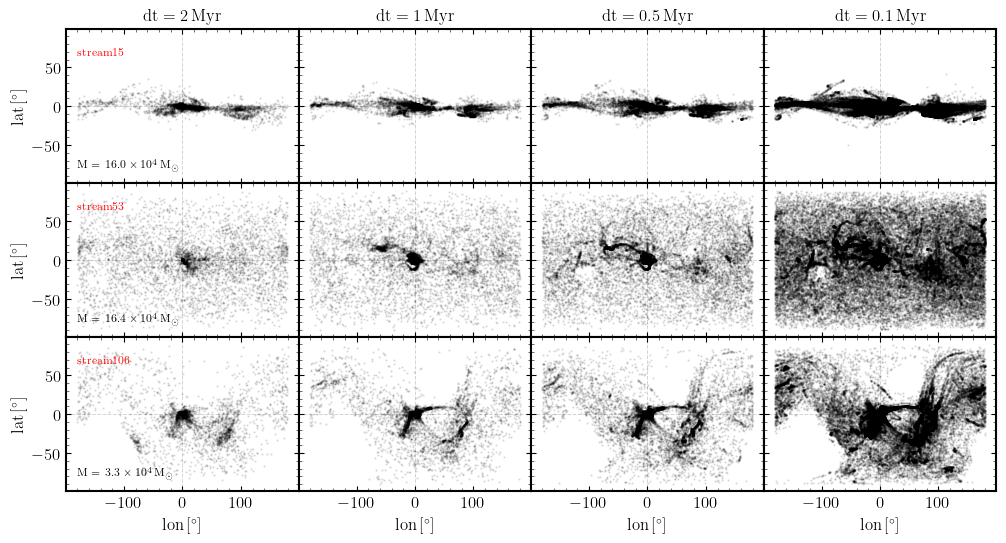

In [4]:
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/" 

stream_frame_comp(data_path, 'dt-stream-frame-comp', False)

dt size vs local velocity dispersion 

In [5]:
def stream_veldis_comp(path, plotname, savefig=False):
    
    # folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    folders = list(['stream15', 'stream53', 'stream106'])
    

    dts = list(['dt_2myr.hdf5', 'dt_1myr.hdf5', 'dt_halfmyr.hdf5', 'dt_tenthmyr.hdf5']) 
    titles = list([r'$\mathrm{dt} = 2\,\mathrm{Myr}$', r'$\mathrm{dt} = 1\,\mathrm{Myr}$', 
                   r'$\mathrm{dt} = 0.5\,\mathrm{Myr}$', r'$\mathrm{dt} = 0.1\,\mathrm{Myr}$'])
    dts_points = np.array([2, 1, 0.5, 0.1])

    fig, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    for i in range(len(folders)): 
        veldis = []
        for j in range(len(dts)):   
            #-------------------------------------------------------------------------------------
            ### Read in the data
            #-------------------------------------------------------------------------------------
            data_path = pathlib.Path(path) / folders[i] / dts[j]
            with h5py.File(data_path,'r') as file:
                loc_veldis = np.array(file['loc_veldis'])
            veldis.append(loc_veldis)
        plt.plot(dts_points, veldis, marker='o', markersize=3,label = folders[i])
    
    plt.xlabel('dt [Myr]')
    plt.ylabel(r'$\sigma_{v,\,\mathrm{loc}}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
    plt.xlim(0.001,2.1)
    plt.ylim(0.1,120)
    plt.legend(frameon=False, fontsize=10, ncol=3)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/{}'.format(plotname))

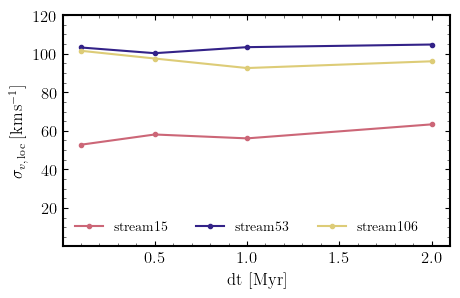

In [6]:
stream_veldis_comp(data_path, 'dt-stream-veldis-comp', False)

time vs closest particle to disc 

In [7]:
def disc_stream_sep(path, plotname, dt, savefig=False):
    
    folders = list(['stream1','stream15', 'stream39', 'stream53', 'stream106'])
    # folders = list(['stream15', 'stream53', 'stream106'])
    fig, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(6,3))
    
    if dt=='halfMyr':
        divison, end = 500, 'dt_halfmyr.hdf5'
        
    if dt=='2Myr':
        divison, end = 250, 'dt_2myr.hdf5'
        
    if dt=='tenthMyr':
        divison, end = 500, 'dt_tenthmyr.hdf5'
    
    for i in range(len(folders)): 
         
        data_path = pathlib.Path(path) / folders[i] / end
        with h5py.File(data_path,'r') as file:
            positions = np.array(file["positions"])
            ts =  np.array(file["times"])[2::2]

        ts_snaps = np.flip(np.flip(ts, axis=0)[::divison])
        disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps])

        stream_rs = np.linalg.norm(positions, axis=2)
        min_disc_stream_sep = np.nanmin(stream_rs, axis=1)
        # min_disc_prog_sep = stream_rs[:,0]
        plt.plot(ts_snaps, min_disc_stream_sep, marker='o', markersize=3, label = folders[i])
        # plt.plot(ts_snaps, stream_rs[:,0], marker='o', markersize=1, label = folders[i])
    # plt.plot(ts_snaps, disc_rs, label='disc')
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$\mathbf{r}_{\mathrm{sep,\,min}}\,[\mathrm{kpc}]$')
    # plt.ylabel(r'$\mathbf{r}(t)\,[\mathrm{kpc}]$')
    plt.xlim(-5, 0.)
    # plt.ylim(0.,30)
    plt.legend(frameon=False, fontsize=10, ncol=3)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname + '_' + dt) )

Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...


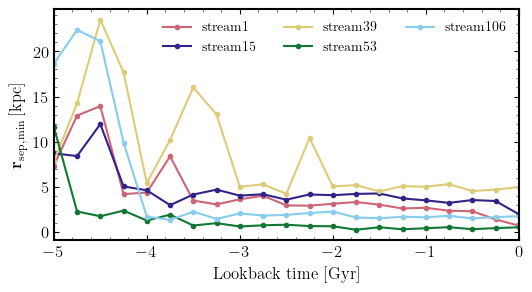

In [8]:
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/" 
disc_stream_sep(data_path, 'disc_stream_sep', 'halfMyr', False)

In [28]:
def exp_centers(ts, plotname, savefig=False):

    plt.figure(figsize=(5,3))

    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts ])
    halo_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[3:6]) for t in ts ])
    lmc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[6:9]) for t in ts ])
    plt.plot(ts, disc_rs, label='Disc')
    plt.plot(ts, halo_rs, label='Halo')
    plt.plot(ts, lmc_rs, label='LMC')
    
    plt.xlabel('Lookback time [Gyr]')
    plt.ylabel(r'$\mathbf{r}_{\mathrm{exp,\,center}}\,[\mathrm{kpc}]$')
    plt.xlim(-5, 0.)
    # plt.ylim(-1, 75)
    plt.legend(frameon=False, fontsize=10)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/{}'.format(plotname) )

425.4231503028718


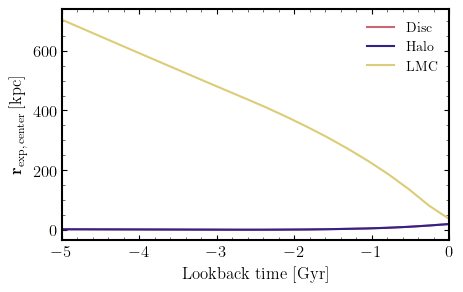

In [29]:
exp_centers(np.linspace(-5,0,20), 'exp-centers', False)

Energy - Angular momentum for all stream particles at different times

In [18]:
from scipy.stats import binned_statistic_2d

In [23]:
def E_L_Lz_evol(path, stream_no, potential, savefig=False):
    
    with h5py.File(path,'r') as file:
        print(np.array(file["pericenter"]))
        energies = np.array(file["energies"])
        Ls = np.array(file["L"])
        Lzs = np.array(file["Lz"])
        ts =  np.array(file["times"])[2::2]
        stream_xs = np.array(file["positions"])
        stream_vs = np.array(file["velocities"])
        
    ### high vel dis
    # ts_snaps = np.flip(np.flip(ts, axis=0)[::500])
    # time_mask = [4, 10, 12, 16, 18, 19, 20]
    
    ### 10kpc cut samples
    ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
    time_mask = [4, 5, 6, 7, 8, 9, 10]
    
    ts_snaps_red = ts_snaps[time_mask]
    Ls_red = Ls[time_mask]
    Lzs_red = Lzs[time_mask]
    energies_red = energies[time_mask]
    
    fig, ax = plt.subplots(len(time_mask), 2, figsize=(6,12), sharey='row', sharex='col')
    plt.subplots_adjust(wspace=0., hspace=0)
    ax[0, 0].set_title(stream_no)
    ax[0, 1].set_title(potential)

    L_bins = np.linspace(np.nanmin(Ls_red[-1]), np.nanmax(Ls_red[-1]), 50)
    # E_bins = np.linspace(np.nanmin(energies_red[-1])/1e4, np.nanmax(energies_red[-1])/1e4, 50)
    E_bins = np.linspace(-14, -6, 50)
    # E_bins = np.linspace(-8, -0, 50)
    Lz_bins = np.linspace(np.nanmin(Lzs_red[-1]), np.nanmax(Lzs_red[-1]), 50)

    for i in range(len(ts_snaps_red)):
       
        # energies_red = energies_vec(ts_snaps_red[i], stream_xs[i], stream_vs[i], mwdflag, mwhflag, lmcflag, motion).value

        lon, lat = lons_lats(stream_xs[i], stream_vs[i])
        bin_medians, _, _, _ = binned_statistic_2d(Ls_red[i][1:], energies_red[i][1:]/1e4,lon, 
                                                   statistic='median', bins=[L_bins, E_bins])
    
        plt.sca(ax[i, 0])
        h, xedges, yedges = np.histogram2d(Ls_red[i], energies_red[i]/1e4, bins = (L_bins, E_bins))
        plt.scatter(Ls_red[i][0], energies_red[i][0]/1e4, marker='*', color='k', s=75, zorder=2)
        plot=plt.pcolormesh(xedges, yedges, bin_medians.T, cmap='jet', vmin=-180, vmax=180, rasterized=True, zorder=1)
        
        # plt.hexbin(Ls_red[i], energies_red/1e4, C=bin_medians, bins = (L_bins, E_bins), cmap='jet')
        plt.xlabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=10)
        plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=10)
        plt.annotate('t = {} Gyr'.format(np.round(ts_snaps_red[i],1)), xy=(L_bins[-25], E_bins[-7]), fontsize=8, color='k')
        # plt.xlim(np.nanmin(Ls_red[-1]),np.nanmax(Ls_red[-1]))
        # plt.xlim(1001, 1999)
        # plt.ylim(-11.9,-8.01)
        # plt.ylim(-7.99,-5.01)

        plt.sca(ax[i, 1])
        
        bin_medians, _, _, _ = binned_statistic_2d(Lzs_red[i][1:], energies_red[i][1:]/1e4,lon, 
                                                   statistic='median', bins=[Lz_bins, E_bins])
        
        h, xedges, yedges = np.histogram2d(Lzs_red[i], energies_red[i]/1e4, bins = (Lz_bins, E_bins)) 
        # plt.scatter(Lzs_red[i][0], energies_red[i][0]/1e4, marker='*', color='k', s=75, zorder=2)
        plot=plt.pcolormesh(xedges, yedges, bin_medians.T, cmap='jet', vmin=-180, vmax=180, rasterized=True, zorder=1)
                                                   
        # plt.hist2d(Lzs_red[i], energies_red/1e4, bins = (Lz_bins,E_bins), cmap='Greys', cmin=1, norm='log')
        plt.xlabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=10)
        # plt.xlim(np.nanmin(Lzs_red[-1]), np.nanmax(Lzs_red[-1]))
        # plt.xlim(-499, 499)

    plt.colorbar(ax=ax, label=r'$\psi_1\,[^{\circ}]$', shrink=.5)
    
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/allparticle-E-L-Lz/{}'.format(stream_no + '_' + potential) )

11.041139627855511


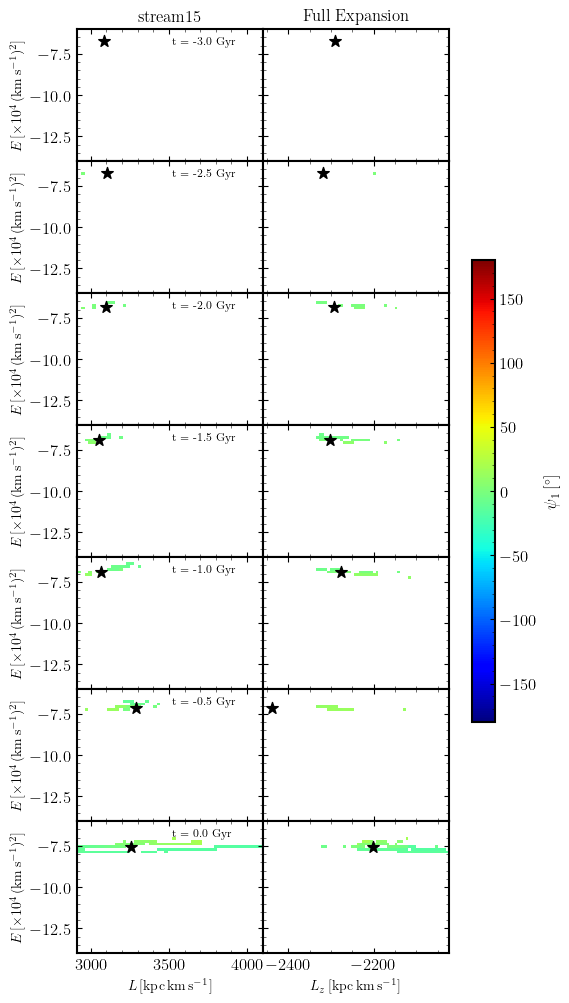

In [22]:
# data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/high-vel-dis/stream1/dt_halfmyr.hdf5" 
# data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/static-mw/stream_15.hdf5" 
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/Full-MWhalo-MWdisc-LMC.hdf5" 

E_L_Lz_evol(data_path, 'stream_15', 'Full Expansion', False)

6.686796102397926


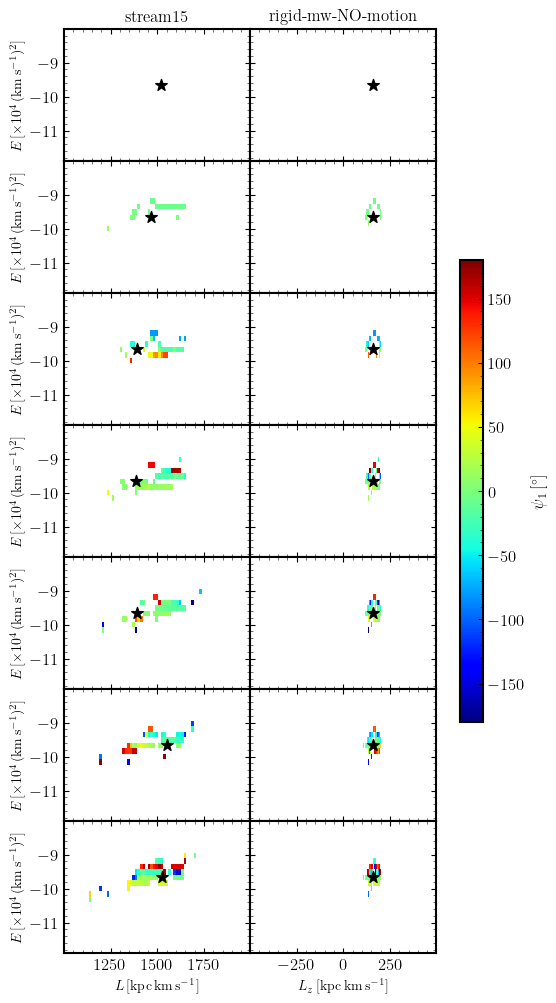

In [264]:
data_path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/rigid-mw/stream_15.hdf5" 

E_L_Lz_evol(data_path, 'stream15', 'rigid-mw-NO-motion', False)

Energy - Angular momentum for all progenitors at different times

In [241]:
def E_L_Lz_evol_progentiors(path, Nstreams, plotname, savefig=False):

    Es =[]
    Ls=[]
    Lzs=[]
    pericenters=[]
    distances=[]
    xs = [] 
    vs = []
    
    for i in range(Nstreams):
        data_path = pathlib.Path(path) 
        with h5py.File(data_path,'r') as file:

            energies = np.array(file['stream_{}'.format(i)]["energies"])[:,0]
            ts = np.array(file['stream_{}'.format(i)]["times"])[2::2]
            prog_xs = np.array(file['stream_{}'.format(i)]["positions"])[:,0]
            prog_vs = np.array(file['stream_{}'.format(i)]["velocities"])[:,0]
            
            L = np.array(file['stream_{}'.format(i)]["L"])[:,0]
            Lz = np.array(file['stream_{}'.format(i)]["Lz"])[:,0]
            peris = np.array(file['stream_{}'.format(i)]["pericenter"])
            # dist = np.linalg.norm(np.array(file['stream_{}'.format(i)]["positions"])[:,0], axis=1)

            xs.append(prog_xs)
            vs.append(prog_vs)
            Es.append(energies)
            Ls.append(L)
            Lzs.append(Lz)
            pericenters.append(peris)
            # distances.append(dist)

            if i==(0):
                ts = np.array(file['stream_{}'.format(i)]["times"])[2::2]
                ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
    # print(np.where( (np.array(Es)[:,-1] / 1e4) < -9) )

    time_mask = [0, 2, 4,  6, 8, 9, 10]
    ts_snaps_red = ts_snaps[time_mask]
    
    print(np.array(Es).shape)

    Ls_red = np.array(Ls)[:,time_mask]
    Lzs_red = np.array(Lzs)[:,time_mask]
    Es_red = np.array(Es)[:,time_mask]
    xs_red = np.array(xs)[:,time_mask]
    vs_red = np.array(vs)[:,time_mask]
    # distances_red = np.array(distances)[:,time_mask]

    fig, ax = plt.subplots(len(time_mask), 2, figsize=(4.5,8.5), sharey='row', sharex='col')
    plt.subplots_adjust(wspace=0., hspace=0)

    for i in range(len(ts_snaps_red)):
        
        # energies_red = energies_vec(ts_snaps[i], xs_red[:,i], vs_red[:,i],63,63,63, True)
        plt.sca(ax[i, 0])
        plt.scatter(Ls_red[:,i], Es_red[:,i]/1e4, c=pericenters, cmap='viridis', s=6, rasterized=True, vmin=5, vmax=25)
        plt.xlabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=8)
        plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=7)
        # plt.annotate('t = {} Gyr'.format(np.round(ts_snaps_red[i],1)), xy=(5000,-8.5), fontsize=8, color='r')
        plt.text(0.75, 0.15, 't = {} Gyr'.format(np.round(ts_snaps_red[i],1)), 
                 horizontalalignment='center', verticalalignment='center', transform=ax[i,0].transAxes,
                fontsize=8)
        plt.xlim(np.nanmin(Ls_red[:,-1])*0.8, np.nanmax(Ls_red[:,-1])*1.2)
        plt.ylim(-14,-3)

        plt.sca(ax[i, 1])
        plt.scatter(Lzs_red[:,i], Es_red[:,i]/1e4, c=pericenters, cmap='viridis', s=6,  rasterized=True, vmin=5, vmax=25)
        plt.xlabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=8)
        plt.xlim(np.nanmin(Lzs_red[:,-1])*1.25, np.nanmax(Lzs_red[:,-1])*1.25)

    plt.colorbar(ax=ax, label='Pericenter [kpc]', shrink=.5)
    # plt.colorbar(ax=ax, label='Distance [kpc]', shrink=.5)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/progenitors-E-L-Lz/{}'.format(plotname) )

(256, 11)


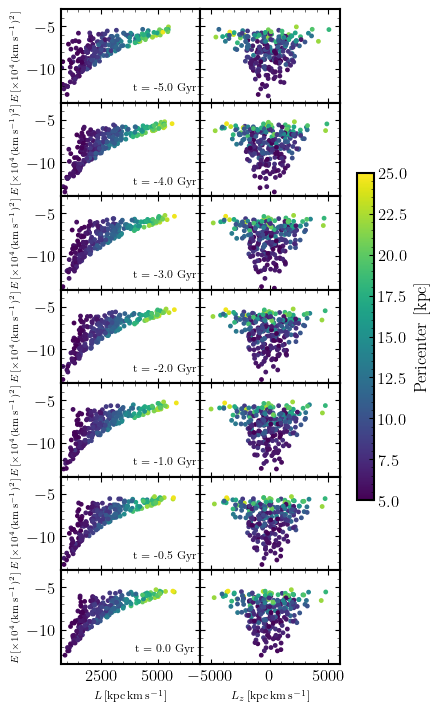

In [266]:
# path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-10rpmin-75ramax/Full-MWhalo-MWdisc-LMC.hdf5"
path = "/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/static-mw.hdf5"

E_L_Lz_evol_progentiors(path, 256, 'rigidmw-motion-5rpmin-cperi', True)

In [43]:
# plt.plot(np.linspace(-5,0,20), [np.linalg.norm(np.cross(np.array(Model.expansion_centres(t)[:3]), 
#                         np.array(Model.expansion_centre_velocities(t)[:3]))) for t in np.linspace(-5,0,20)] )

Energy conservation of particle orbits

In [82]:
def gala_F(t, w, mwdflag, mwhflag, lmcflag, motion):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    
    if motion==False:
        x0 *= 0 
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))


def gala_rewind(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag, motion):

    integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.DOPRI853Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    
    if motion==False:
        mwd_x0 *= 0
        mwd_v0 *= 0
    
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)
    
    # subtract these off
    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    
    if motion==False:
        disk_x0 *= 0
        disk_v0 *= 0
    
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [83]:
def energies_(t, xs, vs, mwdflag, mwhflag, lmcflag):
    """
    calculate the energies and angular momenta of particles for a given time snapshot.
    In the Galactocentric coordinate system. 
    xs,vs are already in GC coords.
    """
    # Kinetic energy
    Ek = (.5 * np.linalg.norm(vs, axis=0)**2) * (u.km/u.s)**2
    # Potential energy
    x0 = np.array(Model.expansion_centres(t))

    # if motion == False:
    #     x0 *= 0 
    
    x_lmc_GC = x0[6:9] - x0[:3]
            
    pot_disk = Model.mwd_fields(t,  xs[0], xs[1], xs[2], mwdflag)[4]
    pot_halo = Model.mwhalo_fields(t, xs[0], xs[1], xs[2], mwhflag)[4]
    pot_lmc = Model.lmc_fields(t, 
                               xs[0] - x_lmc_GC[0],
                               xs[1] - x_lmc_GC[1],
                               xs[2] - x_lmc_GC[2],
                               lmcflag)[4]
    Ep = (pot_disk + pot_halo + pot_lmc) * (u.km/u.s)**2
    E = Ek + Ep
    return E

def angmom_(t, xs, vs, mwdflag, mwhflag, lmcflag):
    """
    calculate the angular momenta of particles for a given time snapshot.
    """
    # Angular momentum
    L = np.linalg.norm(np.cross(xs, vs)) * (u.kpc*u.km/u.s)
    Lz = np.cross(xs[0:2], vs[0:2]) * (u.kpc*u.km/u.s)
    Lx = np.cross(xs[1:], vs[1:]) * (u.kpc*u.km/u.s)
    
    return L, Lz, Lx

In [84]:
def integrate_particle(params, motion):  
    
    inpath, snapname, outpath, filename, \
    fc, Mprog, a_s, pericenter, apocenter, Tbegin, Tfinal, dtmin, \
    mwhflag, mwdflag, lmcflag, strip_rate, \
    static_mwh, static_mwd, lmc_switch = params

    if static_mwh==True:
        _, MWHcoeffs = Model.return_mw_coefficients()
        MWHcoeffs = np.array(MWHcoeffs)
        MWHcoeffs[:,0] = MWHcoeffs[:,0][0] 
        MWHcoeffs[:,1:] = MWHcoeffs[:,1:]*0
        Model.install_mw_coefficients(MWHcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled
        _, MWHcoeffs = Model.return_mw_coefficients()
        assert np.allclose(np.array(MWHcoeffs)[:,1:],0)==True, "MW halo coefficients need to be set to zero"
        
    if static_mwd==True:
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        MWDctmp, MWDstmp = np.array(MWDctmp), np.array(MWDstmp)
        MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0], MWDstmp[:,0][0]
        MWDctmp[:,1:], MWDstmp[:,1:] = MWDctmp[:,1:]*0, MWDstmp[:,1:]*0
        Model.install_disc_coefficients(MWDctmp,MWDstmp)
        #Some line of code here to check they have been set to zero and reinstalled.
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        assert np.allclose(np.array(MWDctmp)[:,1:],0)==True, "MW disc coefficients (c) need to be set to zero"
        assert np.allclose(np.array(MWDstmp)[:,1:],0)==True, "MW disc coefficients (s) need to be set to zero"
        
    if lmc_switch==True:
        _, LMCcoeffs = Model.return_lmc_coefficients()
        LMCcoeffs = np.array(LMCcoeffs)
        LMCcoeffs *= 0 
        Model.install_lmc_coefficients(LMCcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled.
        _, LMCcoeffs = Model.return_lmc_coefficients()
        assert np.allclose(np.array(LMCcoeffs),0)==True, "LMC coefficients need to be set to zero"
    

    w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)
    print('rewinding progenitor... returns positions, velocities in Galactocentric coordinates')
    prog_orbit = gala_rewind(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, mwdflag, mwhflag, lmcflag, motion)
    rewind_xs = prog_orbit[0].T
    rewind_vs = prog_orbit[1].T 
    rewind_ts = prog_orbit[2].value

    print("calculating energies & angular momenta in Galactocentric coordinates...")
    Es = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Ls = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Lzs = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    Lxs = np.full(shape=(len(rewind_xs), 1), fill_value=np.nan)
    
    for i in range(len(rewind_xs)): #calculating in the inertial frame of reference
        Es[i] = energies_(rewind_ts[i], rewind_xs[i].value, rewind_vs[i].value, 
                                                       mwdflag, mwhflag, lmcflag)
        Ls[i], Lzs[i], Lxs[i] = angmom_(rewind_ts[i], rewind_xs[i].value, rewind_vs[i].value, 
                                                       mwdflag, mwhflag, lmcflag)   
        
    return rewind_xs, rewind_vs, rewind_ts, Es, Ls, Lzs, Lxs

In [85]:
def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    inpath = d["inpath"]
    snapname = d["snapname"]
    outpath = d["outpath"]
    outname = d["outname"]
    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    pericenter = d["pericenter"]
    apocenter = d["apocenter"]
    Tbegin = d["Tbegin"]
    Tfinal =  d["Tfinal"]
    dtmin  = 0.002 #d["dtmin"]
    haloflag = 0 #d["haloflag"]
    lmcflag = 0 #d["lmcflag"]
    discflag = 0 #d["discflag"]
    strip_rate = d["strip_rate"]
    # discframe = d["discframe"]
    static_mwh = True #d["static_mwh"]
    static_mwd = True #d["mwd_switch"]
    lmc_switch = True #d["lmc_switch"]

    assert type(inpath)==str, "inpath parameter  must be a string"
    assert type(snapname)==str, "snapname parameter must be a string"
    assert type(outpath)==str, "outpath parameter must be a string"
    assert type(outname)==str, "outname parameter must be a string"
    # assert type(prog_ics)==list, "prog_scale parameter must be a "
    assert type(prog_mass)==float, "prog_mass parameter must be a float"
    assert type(prog_scale)==float, "prog_scale parameter must be a float"
    assert type(Tbegin)==float, "Tbegin parameter must be an float"
    assert type(Tfinal)==float, "Tfinal parameter must be an float"
    assert type(dtmin)==float, "dtmin parameter must be an float"
    assert type(haloflag)==int, "haloflag parameter must be an int"
    assert type(lmcflag)==int, "lmcflag parameter must be an int"
    assert type(discflag)==int, "discflag parameter must be an int"
    assert type(strip_rate)==int, "strip_rate parameter must be an int"

    return [inpath, snapname, outpath, outname, prog_ics ,prog_mass, prog_scale, pericenter, apocenter, Tbegin, Tfinal, dtmin, 
            haloflag, discflag, lmcflag, strip_rate, static_mwh, static_mwd, lmc_switch]

In [231]:
# file = "../ics/high-vel-dis/param_15.yaml"
file = "../ics/rigid-mw/param_1021.yaml"
params = readparams(file)
params

['/mnt/home/rbrooks/ceph/oceanus/ics/rigid-mw',
 'param_1021',
 '/mnt/home/rbrooks/ceph/oceanus/analysis/stream-runs/rigid-mw/',
 'stream_1021',
 array([-3.92027266e-01, -3.54842020e+00, -4.15377627e+01, -5.99231729e-02,
        -6.48781454e-02,  2.03329141e-02]),
 17038.01792976809,
 0.002,
 13.561989333570036,
 42.753001514809284,
 -5.0,
 0.0,
 0.002,
 0,
 0,
 0,
 2,
 True,
 True,
 True]

In [19]:
motion = False
rigid_xs, rigid_vs, rigid_ts, rigid_energies, rigid_Ls, rigid_Lzs, rigid_Lxs = integrate_particle(params, motion)

rewinding progenitor... returns positions, velocities in Galactocentric coordinates
calculating energies & angular momenta in Galactocentric coordinates...


In [44]:
motion = True
static_xs, static_vs, static_ts, static_energies, static_Ls, static_Lzs, static_Lxs = integrate_particle(params, motion)

rewinding progenitor... returns positions, velocities in Galactocentric coordinates
calculating energies & angular momenta in Galactocentric coordinates...


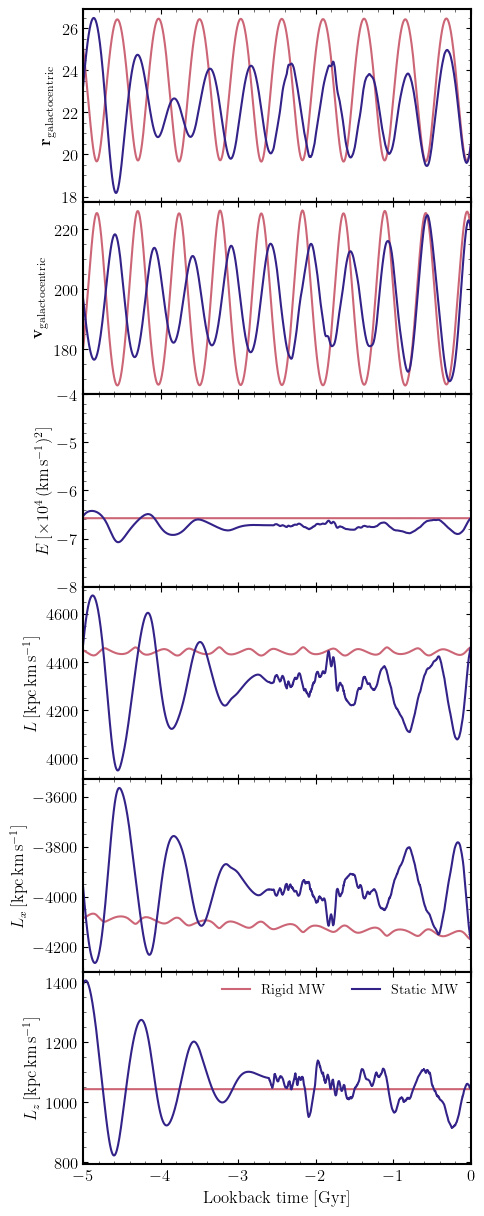

In [23]:
fig, ax  = plt.subplots(6,1, figsize=(5, 15), sharex=True)

plt.subplots_adjust(hspace=0)

plt.sca(ax[0])
plt.plot(rigid_ts, np.linalg.norm(rigid_xs, axis=1), label='Rigid MW')
plt.plot(static_ts, np.linalg.norm(static_xs, axis=1), label='Static MW')
# plt.plot(ts, [np.linalg.norm(Model.expansion_centres(t)[:3]) for t in ts], label='Disc')
# plt.ylim(0,)
plt.ylabel(r'$\mathbf{r}_{\mathrm{galactocentric}}$')

plt.sca(ax[1])
plt.plot(rigid_ts, np.linalg.norm(rigid_vs, axis=1))
plt.plot(static_ts, np.linalg.norm(static_vs, axis=1))
# plt.plot(ts, [np.linalg.norm(Model.expansion_centre_velocities(t)[:3]) for t in ts])
# plt.ylim(0,)
plt.ylabel(r'$\mathbf{v}_{\mathrm{galactocentric}}$')

plt.sca(ax[2])
plt.plot(rigid_ts, rigid_energies/1e4)
plt.plot(static_ts, static_energies/1e4)
plt.ylim(-8,-4)
plt.ylabel(r'$E\,[\times 10^{4}\,(\mathrm{km}\,\mathrm{s}^{-1})^2]$')

plt.sca(ax[3])
plt.plot(rigid_ts, rigid_Ls)
plt.plot(static_ts, static_Ls)
plt.ylabel(r'$L\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')

plt.sca(ax[4])
plt.plot(rigid_ts, rigid_Lxs)
plt.plot(static_ts, static_Lxs)
plt.ylabel(r'$L_x\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')

plt.sca(ax[5])
plt.plot(rigid_ts, rigid_Lzs, label='Rigid MW')
plt.plot(static_ts, static_Lzs, label='Static MW')
plt.xlabel('Lookback time [Gyr]')
plt.ylabel(r'$L_z\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')
plt.legend(frameon=False, fontsize=10, ncol=2)

plt.xlim(-5,0.)

# plt.savefig('../analysis/figures/high-vel-dis/rigid-vs-static-MW-orbit-normalstream.pdf')

Spread of energies, angular momentas with time

In [98]:
def spread_E_evol(data_path, stream, potentials, labels, plotname, savefig=False):

    fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    i=0
    for p in potentials:
        
        path = data_path + '/' + p

        with h5py.File(path ,'r') as file:

            stream_file = file[stream]
            print(stream_file.keys())
            energies = np.array(stream_file['energies'])[:,1:]
            Ls = np.array(stream_file['L'])
            Lzs = np.array(stream_file['Lz'])

            ts =  np.array(stream_file["times"])[2::2]
            ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
            stream_xs = np.array(stream_file["positions"])
            stream_vs = np.array(stream_file["velocities"])
            length = np.array(stream_file["lengths"])
            ds = np.array(stream_file["ds"])
        
        sys_spread = []
        for j in range(len(energies)):
                
            lons, lats = lons_lats(stream_xs[j], stream_vs[j])
            
            sigma_E = np.nanstd(energies[j])
            offset_tails = np.nanmedian(energies[j][lons < 0]) - np.nanmedian(energies[j][lons > 0])
            gradient = offset_tails / length
            sys_spread.append(gradient * sigma_E)
            
        plt.sca(ax1)
        plt.plot(ts_snaps, sys_spread, marker='o', markersize=3, label=labels[i] )
        plt.xlabel(r'Lookback time [Gyr]')
        plt.ylabel(r'$\sigma_{E} \times \nabla E_{\mathrm{stream}}\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$')
        plt.xlim(-4.5,0)
        plt.legend(frameon=False, fontsize=8)
        
        i += 1

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.sca(ax2)
    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps ])
    plt.ylabel(r'$\mathbf{r}_{\mathrm{disc}}\,[\mathrm{kpc}]$', color='grey')
    plt.tick_params(axis='y', labelcolor='grey')
    plt.plot(ts_snaps, disc_rs, color='grey', lw=1, alpha=.5)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/integrals-spreads/{}'.format(plotname + '-' + stream) )

In [93]:
def spread_L_evol(data_path, stream, potentials, labels, plotname, savefig=False):

    colors = ['#CC6677', '#332288']
    
    fig, ax1 = plt.subplots(1,1, sharex='col', sharey='row', figsize=(5,3))
    
    i=0
    for p in potentials:
        
        path = data_path + '/' + p
        
        color = colors[i]

        with h5py.File(path ,'r') as file:

            stream_file = file[stream]
            Ls = np.array(stream_file['L'])
            Lzs = np.array(stream_file['Lz'])

            ts =  np.array(stream_file["times"])[2::2]
            ts_snaps = np.flip(np.flip(ts, axis=0)[::1000])
            
        plt.sca(ax1)
        # plt.plot(ts_snaps, np.nanstd(Ls, axis=1), marker='o', markersize=0, label=labels[i], c=color)
        plt.plot(ts_snaps, np.nanstd(Lzs, axis=1), marker='o', ls='solid',  markersize=3, c=color, label=labels[i])
        plt.xlabel(r'Lookback time [Gyr]')
        plt.ylabel(r'$\sigma_{L_{i}}\,[\mathrm{kpc}\,\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.xlim(-4.5,0)
        plt.ylim(0, 99)
        plt.legend(frameon=False, fontsize=8)
        
        i += 1

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    plt.sca(ax2)
    disc_rs = np.array([np.linalg.norm(Model.expansion_centres(t)[9:12]) for t in ts_snaps ])
    plt.ylabel(r'$\mathbf{r}_{\mathrm{disc}}\,[\mathrm{kpc}]$', color='grey')
    plt.tick_params(axis='y', labelcolor='grey')
    plt.plot(ts_snaps, disc_rs, color='grey', lw=1, alpha=.5)
    plt.ylim(0,)
    
    if savefig==False:
        return
    elif savefig==True:
        return plt.savefig('/mnt/ceph/users/rbrooks/oceanus/analysis/figures/high-vel-dis/integrals-spreads/{}'.format(plotname + '-' + stream) )

<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
<KeysViewHDF5 ['L', 'Lx', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
Cannot select a time after the present day! Setting to present day...


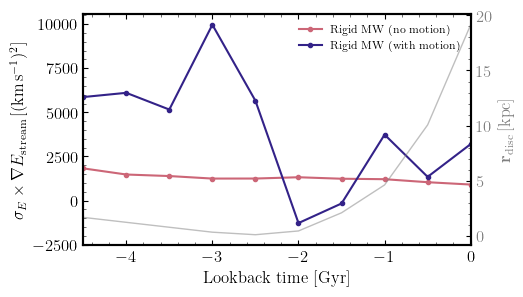

In [99]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-5kpcrpmin/'
pots = ['rigid-mw.hdf5', 'static-mw.hdf5']
labels = ['Rigid MW (no motion)', 'Rigid MW (with motion)']
stream = 'stream_1'

spread_E_evol(path, stream, pots, labels, 'spread_E_evol', False)
# spread_L_evol(path, stream, pots, labels, 'spread_L_evol', False)